## Libraray Import

In [55]:
import pandas as pd; pd.options.mode.chained_assignment = None
import numpy as np

# Built In Imports

from datetime import datetime
from glob import glob
import warnings
import IPython
import urllib
import zipfile
import pickle
import shutil
import string
import math
import tqdm
import time
import os
import gc
import re
import argparse
from pycocotools.coco import COCO
import pandas as pd
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path

# Visualization Imports

from matplotlib.colors import ListedColormap
import matplotlib.patches as patches
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from PIL import Image
import matplotlib
import plotly
import PIL
import cv2
import mmcv
from mmcv import Config
from mmdet.datasets import (build_dataloader, build_dataset,
                            replace_ImageToTensor)
from mmdet.models import build_detector
from mmdet.apis import single_gpu_test
from mmcv.runner import load_checkpoint
import os
from mmcv.parallel import MMDataParallel
import pandas as pd
from pandas import DataFrame
from pycocotools.coco import COCO
import numpy as np
from pycocotools.coco import COCO

# Other Imports

from tqdm.notebook import tqdm

LABELCOLORS = [px.colors.label_rgb(px.colors.convert_to_RGB_255(x)) for x in sns.color_palette("Spectral", 10)]
LABELCOLORSWOUTNOFINDING = LABELCOLORS[:8]+LABELCOLORS[9:]

## Submission to Json

In [ ]:
import pandas as pd
import json

# submission.csv 경로
csv_dir = "/opt/ml/baseline/mmdetection/work_dirs/swinL20_swinbase_ensemble.csv"
pred_df = pd.read_csv(csv_dir) # csv 읽기

dic = {
    "info": {},
    "licenses": [],
    "images": [],               # 이미지 list
    "categories": [],           # class 종류들의 list
    "annotations": []           # annotation list
}

dic["info"] = {
    "year": 2021,
    "version": "1.0",
    "description": "Recycle Trash",
    "contributor": "Upstage",
    "url": None,
    "date_created": "2021-02-02 01:10:00"
}

dic["licenses"] = [
    {
      "id": 0, "name": "CC BY 4.0",
      "url": "https://creativecommons.org/licenses/by/4.0/deed.ast"
    }
]

dic["categories"] = [
    {"id": 0,"name": "General trash","supercategory": "General trash"},
    {"id": 1,"name": "Paper","supercategory": "Paper"},
    {"id": 2,"name": "Paper pack","supercategory": "Paper pack"},
    {"id": 3,"name": "Metal","supercategory": "Metal"},
    {"id": 4,"name": "Glass","supercategory": "Glass"},
    {"id": 5,"name": "Plastic","supercategory": "Plastic"},
    {"id": 6,"name": "Styrofoam","supercategory": "Styrofoam"},
    {"id": 7,"name": "Plastic bag","supercategory": "Plastic bag"},
    {"id": 8,"name": "Battery","supercategory": "Battery"},
    {"id": 9,"name": "Clothing","supercategory": "Clothing"}
]

file_names = pred_df['image_id'].values.tolist()
bboxes = pred_df['PredictionString'].values.tolist()

# dic["images"]
for f in file_names:
    dic["images"].append({
        "width": 1024, "height": 1024,
        "file_name": f,
        "license": 0,
        "flickr_url": None, 
        "coco_url": None,
        "id": int(f[5:9])
    })


box_id = 0
for img_idx,box in enumerate(bboxes):
    lst = []
    if type(box) == float:
        continue
    for i,b in enumerate(box.split(" ")):
        if i%6 == 0 and i != 0:
            # test.json에서는 비어있는 부분
            dic["annotations"].append({
                "image_id": img_idx,          # 이미지 id
                "category_id": int(lst[0]),   # 이미지 class
                "score": float(lst[1]),
                "area": (float(lst[4]) - float(lst[2])) * (float(lst[5]) - float(lst[3])),
                "bbox": [                     # bbox 좌표
                    float(lst[2]),
                    float(lst[3]),
                    float(lst[4]) - float(lst[2]),
                    float(lst[5]) - float(lst[3])
                ],
                "iscrowd": 0,            # ??
                "id": box_id             # 박스의 ID: 1,2,3, ...
            })
            lst = []
            box_id += 1
        lst.append(b)

json_dir = '/opt/ml/baseline/baseline_cv11/swinL20_swinbase_ensemble.json'
with open(json_dir,'w') as f:
    json.dump(dic,f)

## Convert json to dataframe

In [ ]:
coco = COCO('/opt/ml/baseline/baseline_cv11/swinL20_swinbase_ensemble.json')
train_df = pd.DataFrame()
image_ids = []
class_name = []
class_id = []
x_min = []
y_min = []
x_max = []
y_max = []
classes = ["General trash", "Paper", "Paper pack", "Metal", "Glass","Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]

for image_id in coco.getImgIds():
    imageinfo = coco.loadImgs(image_id)[0]
    ann_ids = coco.getAnnIds(imgIds=imageinfo['id'])
    anns = coco.loadAnns(ann_ids)
    filename = imageinfo['file_name']
    for ann in anns:
        image_ids.append(filename)
        class_name.append(classes[ann['category_id']])
        class_id.append(ann['category_id'])
        x_min.append(float(ann['bbox'][0]))
        y_min.append(float(ann['bbox'][1]))
        x_max.append(float(ann['bbox'][0]) + float(ann['bbox'][2]))
        y_max.append(float(ann['bbox'][1]) + float(ann['bbox'][3]))

train_df['imageid'] = image_ids
train_df['classname'] = class_name
train_df['classid'] = class_id
train_df['xmin'] = x_min
train_df['ymin'] = y_min
train_df['xmax'] = x_max
train_df['ymax'] = y_max


loading annotations into memory...
Done (t=1.05s)
creating index...
index created!


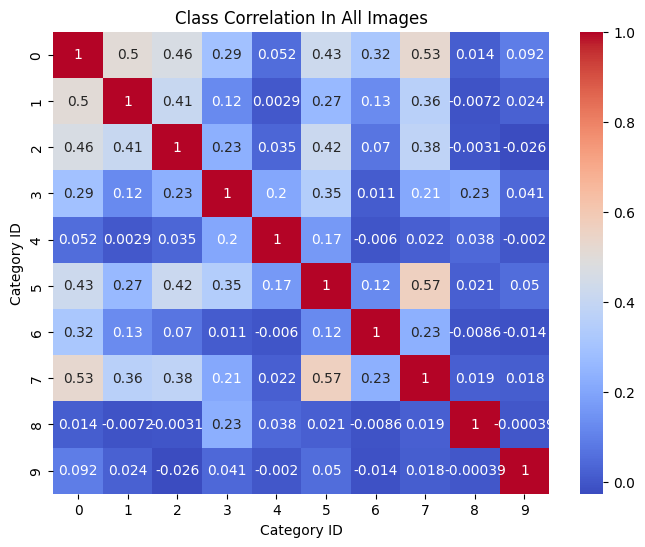

In [ ]:
# 모든 이미지에 대한 상관관계
class_counts = train_df['classid'].value_counts()

# 클래스 간의 상관 행렬 생성
correlation_matrix = train_df.groupby('imageid')['classid'].value_counts().unstack(fill_value=0)
correlation_matrix = correlation_matrix.corr()

# 상관 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.xlabel('Category ID')
plt.ylabel('Category ID')
plt.title('Class Correlation In All Images')
plt.show()

## Confusion Matrix

In [56]:
classes = ("General trash", "Paper", "Paper pack", "Metal", "Glass", 
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing")

# config file 들고오기
cfg = Config.fromfile('/opt/ml/baseline/baseline_cv11/UniverseNet/configs/dyhead/albu_atss_swin-l-p4-w12_fpn_dyhead_mstrain_2x_coco.py')

root='/opt/ml/dataset/images/'

epoch = 'epoch_30'

# dataset config 수정
cfg.data.test.classes = classes
cfg.data.test.img_prefix = root
cfg.data.test.ann_file = root + 'train.json'
cfg.data.test.pipeline[1]['img_scale'] = (1024,1024) # Resize
cfg.data.test.test_mode = True

cfg.data.samples_per_gpu = 2

cfg.seed=2022
cfg.gpu_ids = [0]
cfg.work_dir = '/opt/ml/baseline/baseline_cv11/UniverseNet/work_dirs/albu_atss_swin-l-p4-w12_fpn_dyhead_mstrain_2x_coco_trash'

if "roi_head" in cfg.model.keys():
        if type(cfg.model.roi_head.bbox_head) == dict:
            cfg.model.roi_head.bbox_head.num_classes = 10

        #In case of cascade RCNN : List[Dict]
        elif type(cfg.model.roi_head.bbox_head) == list:
            for each_head in cfg.model.roi_head.bbox_head:
                if hasattr(each_head, "num_classes"):
                    each_head.num_classes = 10 
                else: 
                    raise Exception("Num_classes가 없습니다")
else:
    cfg.model.bbox_head.num_classes = 10
cfg.optimizer_config.grad_clip = dict(max_norm=35, norm_type=2)
cfg.model.train_cfg = None

In [57]:
# build dataset & dataloader
dataset = build_dataset(cfg.data.test)
data_loader = build_dataloader(
        dataset,
        samples_per_gpu=1,
        workers_per_gpu=cfg.data.workers_per_gpu,
        dist=False,
        shuffle=False)

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


In [58]:
# checkpoint path
checkpoint_path = os.path.join(cfg.work_dir, f'{epoch}.pth')

model = build_detector(cfg.model, test_cfg=cfg.get('test_cfg')) # build detector
checkpoint = load_checkpoint(model, checkpoint_path, map_location='cpu') # ckpt load

model.CLASSES = dataset.CLASSES
model = MMDataParallel(model.cuda(), device_ids=[0])

/opt/conda/envs/detection/lib/python3.7/site-packages/mmcv/cnn/bricks/hsigmoid.py:37: UserWarning: In MMCV v1.4.4, we modified the default value of args to align with PyTorch official. Previous Implementation: Hsigmoid(x) = min(max((x + 1) / 2, 0), 1). Current Implementation: Hsigmoid(x) = min(max((x + 3) / 6, 0), 1).
  'In MMCV v1.4.4, we modified the default value of args to align '
/opt/ml/baseline/baseline_cv11/UniverseNet/mmdet/models/dense_heads/anchor_head.py:116: UserWarning: DeprecationWarning: `num_anchors` is deprecated, for consistency or also use `num_base_priors` instead
  warnings.warn('DeprecationWarning: `num_anchors` is deprecated, '


load checkpoint from local path: /opt/ml/baseline/baseline_cv11/UniverseNet/work_dirs/albu_atss_swin-l-p4-w12_fpn_dyhead_mstrain_2x_coco_trash/epoch_30.pth


In [59]:
output = single_gpu_test(model, data_loader, show_score_thr=0.05) # output 계산

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 4883/4883, 3.7 task/s, elapsed: 1319s, ETA:     0s

In [62]:
idx=[0]
coco = COCO(cfg.data.test.ann_file)
for image_id in coco.getImgIds():
    imageinfo = coco.loadImgs(image_id)[0]
    filename = imageinfo['file_name']
    fileidx = filename.split('/')[1].split('.')[0]
    if fileidx!='0000':
        idx.append(int(fileidx.lstrip('0')))

loading annotations into memory...
Done (t=0.09s)
creating index...
index created!


In [63]:
# submission 양식에 맞게 output 후처리
prediction_strings = []
file_names = []
class_num = 10
for i, out in enumerate(output):
    prediction_string = ''
    image_info = coco.loadImgs(coco.getImgIds(imgIds=idx[i]))[0]
    for j in range(class_num):
        for o in out[j]:
            prediction_string += str(j) + ' ' + str(o[4]) + ' ' + str(o[0]) + ' ' + str(o[1]) + ' ' + str(
                o[2]) + ' ' + str(o[3]) + ' '
        
    prediction_strings.append(prediction_string)
    file_names.append(image_info['file_name'])


submission = pd.DataFrame()
submission['PredictionString'] = prediction_strings
submission['image_id'] = file_names
submission.to_csv(os.path.join(cfg.work_dir, f'correlation_{epoch}.csv'), index=None)
submission.head()

,PredictionString,image_id
0,0 0.8242637 196.45963 197.6032 747.1079 662.1934,train/0000.jpg
1,0 0.63590366 421.4794 683.47485 639.6393 862.2...,train/0001.jpg
2,0 0.06460404 263.0711 163.18542 899.52155 675....,train/0002.jpg
3,0 0.06383841 770.3697 0.5809784 965.8758 435.2...,train/0003.jpg
4,0 0.1610791 722.91907 436.42932 769.3098 630.4...,train/0004.jpg


In [64]:
gt_json='/opt/ml/dataset/images/train.json'
pred_csv=f'/opt/ml/baseline/baseline_cv11/UniverseNet/work_dirs/albu_atss_swin-l-p4-w12_fpn_dyhead_mstrain_2x_coco_trash/correlation_epoch_30.csv'
file_name='confusion_matrix.png'

In [65]:
def box_iou_calc(boxes1, boxes2):
    
    def box_area(box):
        # box = 4xn
        return (box[2] - box[0]) * (box[3] - box[1])

    area1 = box_area(boxes1.T)
    area2 = box_area(boxes2.T)

    lt = np.maximum(boxes1[:, None, :2], boxes2[:, :2])  # [N,M,2]
    rb = np.minimum(boxes1[:, None, 2:], boxes2[:, 2:])  # [N,M,2]

    inter = np.prod(np.clip(rb - lt, a_min=0, a_max=None), 2)
    return inter / (area1[:, None] + area2 - inter)  # iou = inter / (area1 + area2 - inter)

class ConfusionMatrix:
    def __init__(self, num_classes: int, CONF_THRESHOLD=0.3, IOU_THRESHOLD=0.5):
        self.matrix = np.zeros((num_classes + 1, num_classes + 1))
        self.num_classes = num_classes
        self.CONF_THRESHOLD = CONF_THRESHOLD
        self.IOU_THRESHOLD = IOU_THRESHOLD

    def plot(self, file_name='./', names=["General trash", "Paper", "Paper pack", "Metal", "Glass", 
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]):
        try:
            import seaborn as sn

            array = self.matrix / (self.matrix.sum(0).reshape(1, self.num_classes + 1) + 1E-6)  # normalize
            array[array < 0.005] = np.nan  # don't annotate (would appear as 0.00)

            fig = plt.figure(figsize=(12, 9), tight_layout=True)
            sn.set(font_scale=1.0 if self.num_classes < 50 else 0.8)  # for label size
            labels = (0 < len(names) < 99) and len(names) == self.num_classes  # apply names to ticklabels
            sn.heatmap(array, annot=self.num_classes < 30, annot_kws={"size": 8}, cmap='Blues', fmt='.2f', square=True,
                       xticklabels=names + ['background FP'] if labels else "auto",
                       yticklabels=names + ['background FN'] if labels else "auto").set_facecolor((1, 1, 1))
            fig.axes[0].set_xlabel('True')
            fig.axes[0].set_ylabel('Predicted')
            
            # if not Path('./result_analysis').exists():
            #     Path('./result_analysis').mkdir(parents=True, exist_ok=True)
            #     fig.savefig(Path('./result_analysis') / file_name, dpi=150)
        except Exception as e:
            print(e)
            pass

    def process_batch(self, detections, labels: np.ndarray):
        """
        Return intersection-over-union (Jaccard index) of boxes.
        Both sets of boxes are expected to be in (x1, y1, x2, y2) format.
        Arguments:
            detections (Array[N, 6]), x1, y1, x2, y2, conf, class
            labels (Array[M, 5]), class, x1, y1, x2, y2
        Returns:
            None, updates confusion matrix accordingly
        """
        gt_classes = labels[:, 0].astype(np.int16)

        try:
            detections = detections[detections[:, 4] > self.CONF_THRESHOLD]
        except IndexError or TypeError:
            # detections are empty, end of process
            for i, label in enumerate(labels):
                gt_class = gt_classes[i]
                self.matrix[self.num_classes, gt_class] += 1
            return

        detection_classes = detections[:, 5].astype(np.int16)

        all_ious = box_iou_calc(labels[:, 1:], detections[:, :4])
        want_idx = np.where(all_ious > self.IOU_THRESHOLD)

        all_matches = [[want_idx[0][i], want_idx[1][i], all_ious[want_idx[0][i], want_idx[1][i]]]
                       for i in range(want_idx[0].shape[0])]

        all_matches = np.array(all_matches)
        if all_matches.shape[0] > 0:  # if there is match
            all_matches = all_matches[all_matches[:, 2].argsort()[::-1]]

            all_matches = all_matches[np.unique(all_matches[:, 1], return_index=True)[1]]

            all_matches = all_matches[all_matches[:, 2].argsort()[::-1]]

            all_matches = all_matches[np.unique(all_matches[:, 0], return_index=True)[1]]

        for i, label in enumerate(labels):
            gt_class = gt_classes[i]
            if all_matches.shape[0] > 0 and all_matches[all_matches[:, 0] == i].shape[0] == 1:
                detection_class = detection_classes[int(all_matches[all_matches[:, 0] == i, 1][0])]
                self.matrix[detection_class, gt_class] += 1
            else:
                self.matrix[self.num_classes, gt_class] += 1

        for i, detection in enumerate(detections):
            if not all_matches.shape[0] or ( all_matches.shape[0] and all_matches[all_matches[:, 1] == i].shape[0] == 0 ):
                detection_class = detection_classes[i]
                self.matrix[detection_class, self.num_classes] += 1

    def return_matrix(self):
        return self.matrix

    def print_matrix(self):
        for i in range(self.num_classes + 1):
            print(' '.join(map(str, self.matrix[i])))

def main():

    conf_mat = ConfusionMatrix(num_classes = 10, CONF_THRESHOLD = 0.01, IOU_THRESHOLD = 0.5)
    gt_path = gt_json
    pred_path = pred_csv
    with open(gt_path, 'r') as outfile:
        test_anno = (json.load(outfile))

    pred_df = pd.read_csv(pred_path)

    new_pred = []

    gt = []

    file_names = pred_df['image_id'].values.tolist()
    bboxes = pred_df['PredictionString'].values.tolist()
    for i, bbox in enumerate(bboxes):
        if isinstance(bbox, float):
            print(f'{file_names[i]} empty box')

    for file_name, bbox in tqdm(zip(file_names, bboxes)):
        new_pred.append([])
        boxes = np.array(str(bbox).split(' '))

        if len(boxes) % 6 == 1:
            boxes = boxes[:-1].reshape(-1, 6)
        elif len(boxes) % 6 == 0:
            boxes = boxes.reshape(-1, 6)
        else:
            raise Exception('error', 'invalid box count')
        for box in boxes:
            new_pred[-1].append([float(box[2]), float(box[3]), float(box[4]), float(box[5]),  float(box[1]), float(box[0])])

    coco = COCO(gt_path)
    
    for image_id in coco.getImgIds():
        gt.append([])
        image_info = coco.loadImgs(image_id)[0]
        ann_ids = coco.getAnnIds(imgIds=image_info['id'])
        anns = coco.loadAnns(ann_ids)
        
        file_name = image_info['file_name']
        
        for ann in anns:
            gt[-1].append([
                       float(ann['category_id']),
                       float(ann['bbox'][0]),
                       float(ann['bbox'][1]),
                       float(ann['bbox'][0]) + float(ann['bbox'][2]),
                       (float(ann['bbox'][1]) + float(ann['bbox'][3])),  
                       ]
                       )
    for p, g in zip(new_pred, gt):
        conf_mat.process_batch(np.array(p), np.array(g))
    conf_mat.plot(file_name)

0it [00:00, ?it/s]

loading annotations into memory...
Done (t=0.08s)
creating index...
index created!


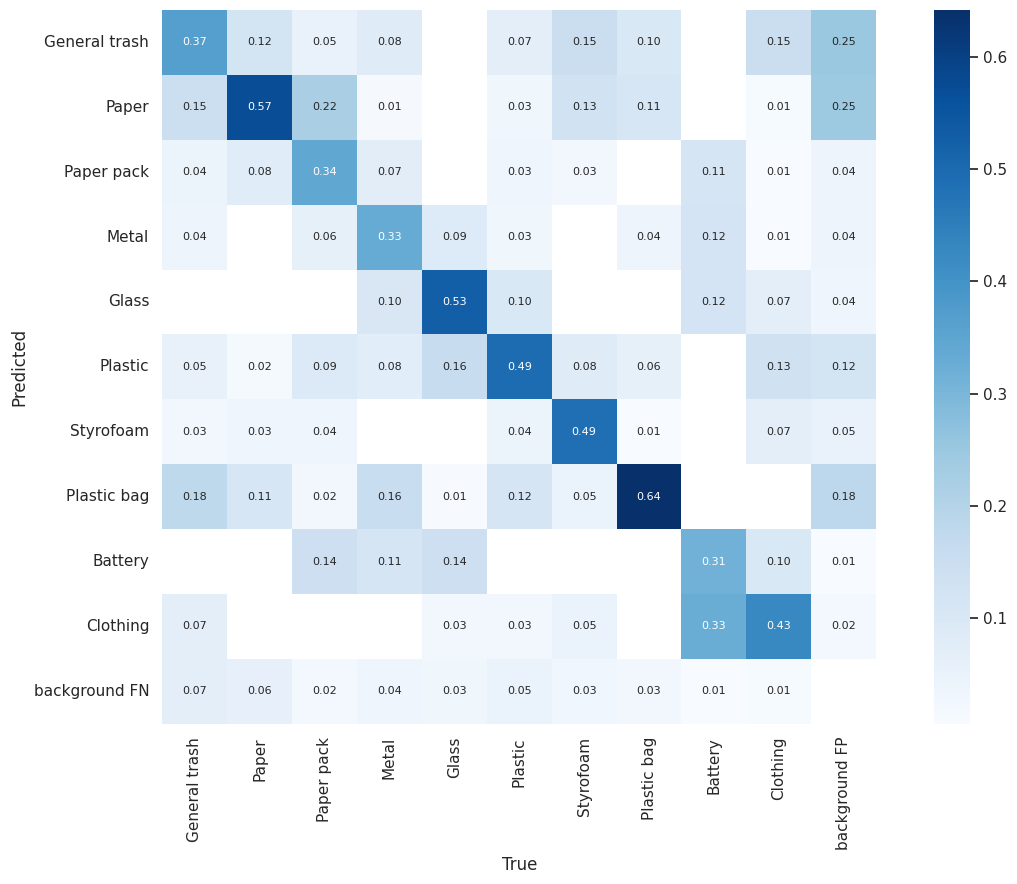

In [66]:
main()